In [5]:
import numpy as np
import pandas as pd
import sys,os
import pylab
from scipy import stats,signal,io
import matplotlib.pyplot as plt
from sklearn import linear_model
import pickle
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
import h5py
import matplotlib.gridspec as gridspec
plt.rcParams['pdf.fonttype'] = 'truetype'
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from functools import reduce
import datetime

import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
from spikeinterface.exporters import export_to_phy


import argparse
from subprocess import call
import time

from glob import glob

from probeinterface import get_probe, read_prb

In [2]:
base_path = '/n/groups/datta/guitchounts/data/gmou48/gmou48_2021-12-11_14-24-38_odor/'

data = se.read_openephys(glob('%s/Record*' % base_path)[0])
probe = read_prb('/home/gg121/code/spikeinterface_analysis/A4x16-Poly3-5mm-20-200-160-H64LP.prb').probes[0]
recording = data.set_probe(probe)


/n/groups/datta/guitchounts/data/gmou48/gmou48_2021-12-11_14-24-38_odor/Record Node 101/experiment1/recording1/continuous/Rhythm_FPGA-100.0/continuous.dat
/n/groups/datta/guitchounts/data/gmou48/gmou48_2021-12-11_14-24-38_odor/Record Node 101/experiment1/recording1/continuous/Rhythm_FPGA-100.0/continuous.dat


In [3]:
recording = st.preprocessing.notch_filter(recording,freq=60)

recording_f = st.preprocessing.bandpass_filter(recording, freq_min=300, freq_max=6000)
recording_cmr = st.preprocessing.common_reference(recording_f, reference='global',  operator='median')



In [4]:
num_workers = 8


default_ms4_params = ss.Mountainsort4Sorter.default_params()
#print(default_ms4_params)
ms4_params = default_ms4_params.copy()
ms4_params['adjacency_radius'] = 50
ms4_params['detect_sign'] = 0
ms4_params['filter'] = False
ms4_params['num_workers'] = num_workers

ms4_params['clip_size'] = 64 # waveform is 64 samples
ms4_params['detect_interval'] = 15 # 0.5 ms (?)

fs = 3e4


In [5]:
ms4_params

{'detect_sign': 0,
 'adjacency_radius': 50,
 'freq_min': 300,
 'freq_max': 6000,
 'filter': False,
 'whiten': True,
 'num_workers': 8,
 'clip_size': 64,
 'detect_threshold': 3,
 'detect_interval': 15}

In [ ]:
#### run sorting:
print('Starting mountainsort4 sorting....')
start = time.time()
# run Mountainsort:
sorting_MS4 = ss.run_sorter('mountainsort4',recording_cmr,  # parallel=True,
                       verbose=True,
                       output_folder='%s/tmp_MS4' % base_path, **ms4_params)

print('sorting finished in %f seconds...' % (time.time() - start) )


In [ ]:
6361.254470 / 60

In [7]:
sorting_MS4 = si.core.NpzSortingExtractor('%s/tmp_MS4/firings.npz' % base_path)

In [8]:
sorting_MS4

NpzSortingExtractor: 227 units - 1 segments - 30.0kHz
  file_path: /n/groups/datta/guitchounts/data/gmou48/gmou48_2021-12-11_14-24-38_odor/tmp_MS4/firings.npz

In [9]:
folder = '%s/tmp_MS4/waveforms' % base_path
we = si.extract_waveforms(recording_cmr, sorting_MS4, folder,ms_before=1,ms_after=1.0,load_if_exists=True,
                         n_jobs=8, total_memory='1G') # 

/n/groups/datta/guitchounts/data/gmou48/gmou48_2021-12-11_14-24-38_odor/Record Node 101/experiment1/recording1/continuous/Rhythm_FPGA-100.0/continuous.dat/n/groups/datta/guitchounts/data/gmou48/gmou48_2021-12-11_14-24-38_odor/Record Node 101/experiment1/recording1/continuous/Rhythm_FPGA-100.0/continuous.dat/n/groups/datta/guitchounts/data/gmou48/gmou48_2021-12-11_14-24-38_odor/Record Node 101/experiment1/recording1/continuous/Rhythm_FPGA-100.0/continuous.dat


/n/groups/datta/guitchounts/data/gmou48/gmou48_2021-12-11_14-24-38_odor/Record Node 101/experiment1/recording1/continuous/Rhythm_FPGA-100.0/continuous.dat/n/groups/datta/guitchounts/data/gmou48/gmou48_2021-12-11_14-24-38_odor/Record Node 101/experiment1/recording1/continuous/Rhythm_FPGA-100.0/continuous.dat

/n/groups/datta/guitchounts/data/gmou48/gmou48_2021-12-11_14-24-38_odor/Record Node 101/experiment1/recording1/continuous/Rhythm_FPGA-100.0/continuous.dat/n/groups/datta/guitchounts/data/gmou48/gmou48_2021-12-11_14-24-38_odor

In [10]:
x = we.get_waveforms(unit_id=10)

In [11]:
x.shape

(132, 60, 64)

In [12]:
np.where(x)

(array([  0,   0,   0, ..., 131, 131, 131]),
 array([ 0,  0,  0, ..., 59, 59, 59]),
 array([ 0,  1,  2, ..., 61, 62, 63]))

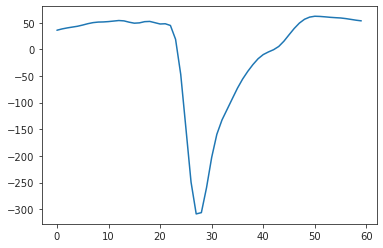

In [13]:
plt.plot(x[:,:,0].mean(axis=0))

In [14]:
pc = st.compute_principal_components(we, load_if_exists=True,
                                     n_components=3, mode='by_channel_local')

(500, 3, 64)
(500, 3, 64)
(500, 3, 64)


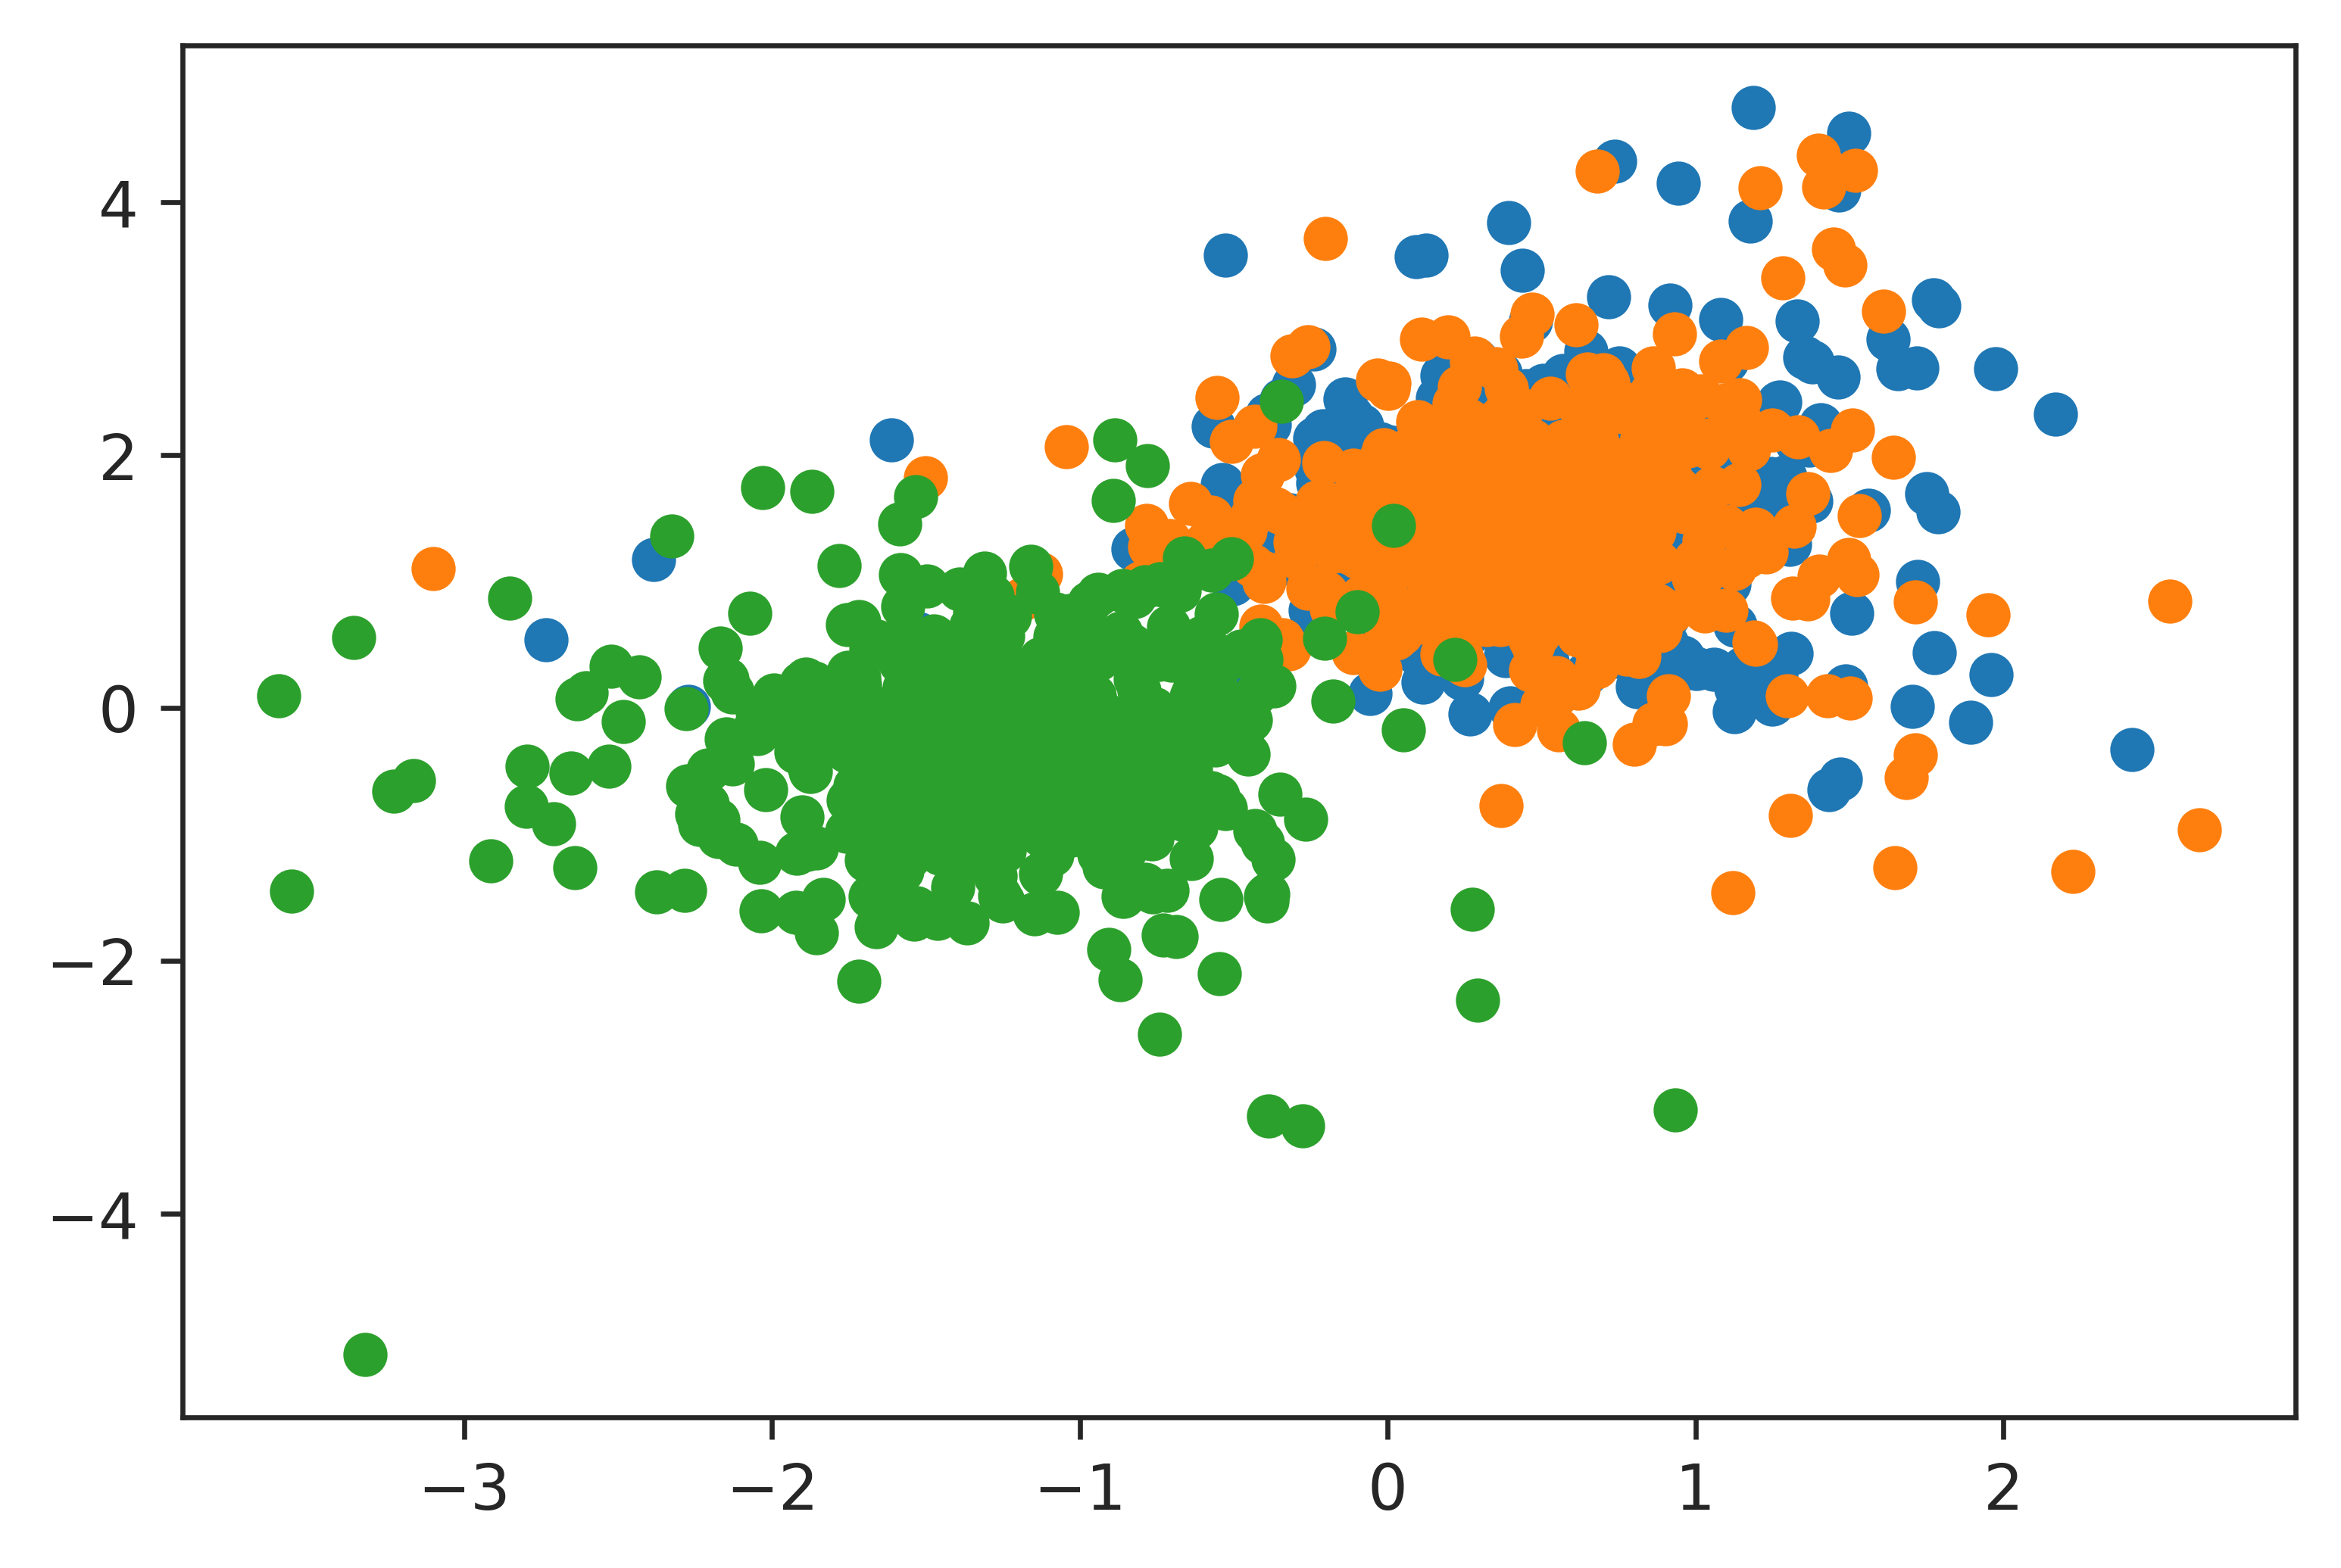

In [18]:
fig, ax = plt.subplots(dpi=600)

for i, unit_id in enumerate(sorting_MS4.unit_ids[0:3]):
    comp = pc.get_components(unit_id)
    print(comp.shape)
    #color = colors[i]
    ax.scatter(comp[:, 0, 8], comp[:, 1, 8],) #  color=color

In [19]:
pc

PosixPath('/n/groups/datta/guitchounts/data/gmou48/gmou48_2021-12-11_14-24-38_odor/tmp_MS4/waveforms')

In [21]:
output_folder = '%s/tmp_MS4/phy' % base_path 

export_to_phy(we, output_folder, 
              n_jobs=8, total_memory='1G',
              #peak_sign='neg',
              copy_binary=False,
              progress_bar=True, #verbose=True,
            #remove_if_exists=True,
              )


/n/groups/datta/guitchounts/data/gmou48/gmou48_2021-12-11_14-24-38_odor/Record Node 101/experiment1/recording1/continuous/Rhythm_FPGA-100.0/continuous.dat
/n/groups/datta/guitchounts/data/gmou48/gmou48_2021-12-11_14-24-38_odor/Record Node 101/experiment1/recording1/continuous/Rhythm_FPGA-100.0/continuous.dat
/n/groups/datta/guitchounts/data/gmou48/gmou48_2021-12-11_14-24-38_odor/Record Node 101/experiment1/recording1/continuous/Rhythm_FPGA-100.0/continuous.dat
/n/groups/datta/guitchounts/data/gmou48/gmou48_2021-12-11_14-24-38_odor/Record Node 101/experiment1/recording1/continuous/Rhythm_FPGA-100.0/continuous.dat
/n/groups/datta/guitchounts/data/gmou48/gmou48_2021-12-11_14-24-38_odor/Record Node 101/experiment1/recording1/continuous/Rhythm_FPGA-100.0/continuous.dat
/n/groups/datta/guitchounts/data/gmou48/gmou48_2021-12-11_14-24-38_odor/Record Node 101/experiment1/recording1/continuous/Rhythm_FPGA-100.0/continuous.dat
/n/groups/datta/guitchounts/data/gmou48/gmou48_2021-12-11_14-24-38_odo

extract amplitudes:   0%|                                                                                                                                                                                                      | 0/120 [00:00<?, ?it/s]

/n/groups/datta/guitchounts/data/gmou48/gmou48_2021-12-11_14-24-38_odor/Record Node 101/experiment1/recording1/continuous/Rhythm_FPGA-100.0/continuous.dat


extract amplitudes: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [03:40<00:00,  1.84s/it]


/n/groups/datta/guitchounts/data/gmou48/gmou48_2021-12-11_14-24-38_odor/Record Node 101/experiment1/recording1/continuous/Rhythm_FPGA-100.0/continuous.dat
/n/groups/datta/guitchounts/data/gmou48/gmou48_2021-12-11_14-24-38_odor/Record Node 101/experiment1/recording1/continuous/Rhythm_FPGA-100.0/continuous.dat
/n/groups/datta/guitchounts/data/gmou48/gmou48_2021-12-11_14-24-38_odor/Record Node 101/experiment1/recording1/continuous/Rhythm_FPGA-100.0/continuous.dat
/n/groups/datta/guitchounts/data/gmou48/gmou48_2021-12-11_14-24-38_odor/Record Node 101/experiment1/recording1/continuous/Rhythm_FPGA-100.0/continuous.dat
/n/groups/datta/guitchounts/data/gmou48/gmou48_2021-12-11_14-24-38_odor/Record Node 101/experiment1/recording1/continuous/Rhythm_FPGA-100.0/continuous.dat
/n/groups/datta/guitchounts/data/gmou48/gmou48_2021-12-11_14-24-38_odor/Record Node 101/experiment1/recording1/continuous/Rhythm_FPGA-100.0/continuous.dat
/n/groups/datta/guitchounts/data/gmou48/gmou48_2021-12-11_14-24-38_odo

extract PCs:   0%|                                                                                                                                                                                                             | 0/120 [00:00<?, ?it/s]

/n/groups/datta/guitchounts/data/gmou48/gmou48_2021-12-11_14-24-38_odor/Record Node 101/experiment1/recording1/continuous/Rhythm_FPGA-100.0/continuous.dat


extract PCs: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [35:06<00:00, 17.55s/it]


Run:
phy template-gui  /n/groups/datta/guitchounts/data/gmou48/gmou48_2021-12-11_14-24-38_odor/tmp_MS4/phy/params.py


In [ ]:
os.listdir('/n/groups/datta/guitchounts/data/gmou48/gmou48_2021-12-11_14-24-38_odor/tmp_MS4/')

In [20]:
! rm -r /n/groups/datta/guitchounts/data/gmou48/gmou48_2021-12-11_14-24-38_odor/tmp_MS4/phy

In [19]:
! rm -r /n/groups/datta/guitchounts/data/gmou48/gmou48_2021-12-11_14-24-38_odor/tmp_MS4/waveforms

In [ ]:
sys.version_info
